In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
y = pd.read_csv("AAPL_quarterly_financials.csv")

In [3]:
y.index = y.name

Select the "BasicEPS" column and keep only the rows starting from the third row (since the first two rows contain non-numeric values)

In [4]:
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:,:]

Convert the index to datetime format

In [5]:
y.index = pd.to_datetime(y.index)

Check if there are any missing values in the "BasicEPS" column and replace them with 0

Sort the DataFrame by index

In [6]:
# CHECK IF NAS ARE NO DIVIDEND PERIOD
y = y.sort_index().fillna(0.)

In [7]:
y.head()

,BasicEPS
1985-09-30,0.0
1985-12-31,0.004
1986-03-31,0.002
1986-06-30,0.002
1986-09-30,0.0


# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data

In [8]:
!pip install pytrends

Create a TrendReq object to fetch Google Trends data

In [9]:
from pytrends.request import TrendReq

In [10]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Example Phrase 1", "Example Phrase 2"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

Resample the Google Trends data to quarterly frequency and align it with the EPS data

In [11]:
X = df.resample("Q").mean()

In [12]:
# ALIGN DATA
temp = pd.concat([y, X],axis = 1).dropna()
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()

# 3.) Normalize all the X data

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()

In [15]:
X_Scaled = scaler.fit_transform(X)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

- Lambda is the tuning parameter that controls the strength of the penalty, where larger values of lambda create simpler models with more coefficients shrunk towards zero. 
- Coefficients that do not add significant explanation to the dependent data will be shrunk to zero
- When Lambda = 0, this becomes an OLS regression

### ***Case when Lambda = 0***

In [16]:
from sklearn.linear_model import Lasso

In [27]:
lasso = Lasso(alpha = 0)

In [28]:
lasso.fit(X_Scaled, y)

C:\Users\akudu\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\akudu\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0)

In [29]:
coefficients = lasso.coef_

In [30]:
coefficients

array([ 0.29871217, -0.0143263 ])

In [31]:
non_zero_indices = [i for i, coef in enumerate(coefficients) if coef != 0]
print(f"Non-zero coefficient indices: {non_zero_indices}")

Non-zero coefficient indices: [0, 1]


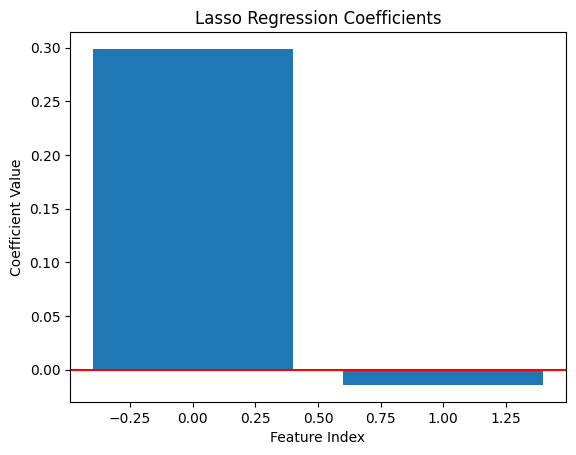

In [32]:
# Plot a bar chart
plt.bar(range(len(coefficients)), coefficients)
plt.axhline(0.,color = "red")
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression Coefficients')
plt.show()

### ***Case when Lambda = 0.5***

In [37]:
lasso = Lasso(alpha = 0.5)

In [38]:
lasso.fit(X_Scaled, y)

Lasso(alpha=0.5)

In [39]:
coefficients = lasso.coef_

In [40]:
coefficients

array([0., 0.])

In [41]:
non_zero_indices = [i for i, coef in enumerate(coefficients) if coef != 0]
print(f"Non-zero coefficient indices: {non_zero_indices}")

Non-zero coefficient indices: []


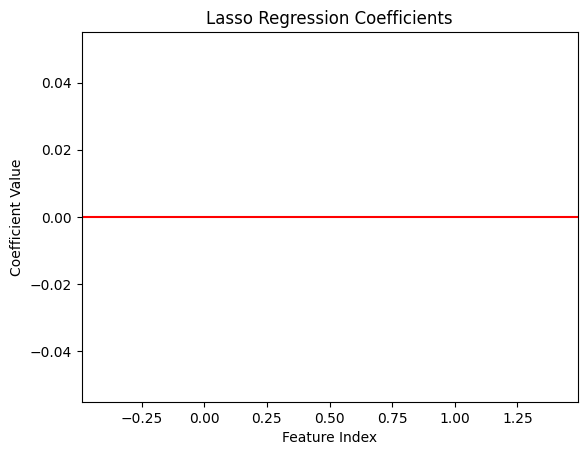

In [42]:
# Plot a bar chart
plt.bar(range(len(coefficients)), coefficients)
plt.axhline(0.,color = "red")
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression Coefficients')
plt.show()

- As we can see from the two graphs above, increasing the lambda from 0 to 0.5 penalized the coefficients more. As a result, the unimportant ones were shrunk to 0.

# 5.) Do these coefficient magnitudes make sense?

When interpreting Lasso Coefficients, one should keep in mind that we cannot interpret them as it is (unlike Linear Regression Coefficients)
- In order to interpret them, we need to find a way to unnormalize them
- Lasso is majorly used for **Feature Selection** and the magnitude of the coefficients come to play in this case
- When the magnitude is high, we can say that the coefficients are most important in predicting our dependent variable
- When the magnitude is low / zero, we can say that the coefficients are the least important

**In the case of LAMBDA = 0.5**

All coefficients were reduced to zero meaning none of them were important in predicting the EPS.It essentially means that the model is selecting none of the features from the Google Trends data to predict the earnings per share (EPS).
- It could suggest that the chosen search terms are not informative or relevant for predicting Apple's quarterly earnings.
- Alternatively, it might indicate that the relationship between the selected search terms and earnings is not linear, and Lasso (which applies L1 regularization) may not be the most suitable method for capturing the underlying patterns.